In [64]:
import pandas as pd
import numpy as np

# Define the path to the CSV file
league = "ligue-1-fr"
forecasts_csv_path = f"./forecasts/"+league+"_forecasts_all.csv"

data = pd.read_csv(forecasts_csv_path, header=None)

# The first row contains player names, and the second row contains scores
# We'll create a DataFrame using the first row for column names and the second row for data
player_names = data.iloc[0, :].values
expected_scores = data.iloc[1, :].values
upper_bound = data.iloc[2, :].values
lower_bound = data.iloc[3, :].values

# Create a DataFrame from these arrays
vertical_df = pd.DataFrame({
    "Slug": player_names,
    "Lower Bound": lower_bound,
    "Expected Score": expected_scores,
    "Upper Bound": upper_bound
})
vertical_df['Expected Score'] = pd.to_numeric(vertical_df['Expected Score'][1:])
vertical_df['Upper Bound'] = pd.to_numeric(vertical_df['Upper Bound'][1:])
vertical_df['Lower Bound'] = pd.to_numeric(vertical_df['Lower Bound'][1:])
vertical_df.loc[vertical_df['Expected Score'] > 100, 'Expected Score'] = 100
vertical_df.loc[vertical_df['Upper Bound'] > 100, 'Upper Bound'] = 100

# Now sort the DataFrame by 'Expected Score' in descending order
vertical_df = vertical_df[1:]
vertical_df.sort_values(by="Expected Score", ascending=False, inplace=True)
vertical_df

,Slug,Lower Bound,Expected Score,Upper Bound
76,clinton-mukoni-mata-pedro-lourenco,28.914221,100.000000,80.642959
272,morgan-sanson,72.150000,91.500000,99.330000
48,benjamin-bourigeaud,45.301022,91.087067,100.000000
325,samuel-gigot,84.200000,84.200000,84.200000
316,remy-descamps,63.275424,82.366217,100.000000
...,...,...,...,...
151,ismael-landry-doukoure,9.116523,16.700000,21.676407
333,shamar-nicholson,5.888393,16.033677,47.144579
5,adam-jakubech,0.000000,15.627002,55.565172
248,matthieu-dreyer,9.100000,9.100000,75.600000


In [65]:
import os
import json

# Define the path to the clubs directory
clubs_dir_path = "./data/" + league + "/clubs"

# Initialize dictionaries to map player slugs to their club names, positions, last scores, and L9 average scores
player_data_mapping = {}

# Iterate over each file in the clubs directory
for filename in os.listdir(clubs_dir_path):
    if filename.endswith(".json"):
        # Extract club name from the filename
        club_name = filename[:-5]  # Remove '.json' extension
        
        # Load the JSON file
        with open(os.path.join(clubs_dir_path, filename)) as f:
            club_data = json.load(f)
        
        # Iterate over the players in the JSON file
        for player in club_data["football"]["club"]["activePlayers"]["nodes"]:
            player_slug = player["slug"]
            position = player.get("position", "Unknown")
            
            # Extract the last score for the player (assuming the first score is the most recent one)
            if player.get("so5Scores"):
                last_score = player["so5Scores"][0].get("score", 0)
                # Calculate L9 as the average of the rest excluding zeros
                rest_scores = [score["score"] for score in player["so5Scores"][1:] if score["score"] != 0]
                l9_average = sum(rest_scores) / len(rest_scores) if rest_scores else 0
            else:
                last_score = 0
                l9_average = 0
            
            player_data_mapping[player_slug] = {
                "Club": club_name,
                "Position": position,
                "Last Score": last_score,
                "L9": l9_average
            }

# For each player in the vertical_df, find their club name, position, last score, and L9 average using the mappings
for col in ["Club", "Position", "Last Score", "L9"]:
    vertical_df[col] = vertical_df['Slug'].apply(lambda x: player_data_mapping.get(x, {}).get(col, None))

for col in vertical_df.columns:
    if vertical_df[col].dtype == 'float64':  # Check if the column is of float dtype
        # Convert to numeric, coercing errors, which turns problematic values to NaN
        vertical_df[col] = vertical_df[col].round()

vertical_df

,Slug,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9
76,clinton-mukoni-mata-pedro-lourenco,29.0,100.0,81.0,olympique-lyonnais-lyon,Defender,55.0,58.0
272,morgan-sanson,72.0,92.0,99.0,nice-nice,Midfielder,30.0,42.0
48,benjamin-bourigeaud,45.0,91.0,100.0,rennes-rennes,Midfielder,69.0,53.0
325,samuel-gigot,84.0,84.0,84.0,olympique-marseille-marseille,Defender,0.0,43.0
316,remy-descamps,63.0,82.0,100.0,nantes-la-chapelle-sur-erdre,Goalkeeper,0.0,31.0
...,...,...,...,...,...,...,...,...
151,ismael-landry-doukoure,9.0,17.0,22.0,strasbourg-strasbourg,Defender,0.0,21.0
333,shamar-nicholson,6.0,16.0,47.0,clermont-clermont-ferrand,Forward,0.0,45.0
5,adam-jakubech,0.0,16.0,56.0,lille-villeneuve-d-ascq,Goalkeeper,0.0,0.0
248,matthieu-dreyer,9.0,9.0,76.0,strasbourg-strasbourg,Goalkeeper,0.0,0.0


In [66]:
import os
import json

# ... (previous code remains the same)

# Load the players.json file
with open("./playsharper/data/players.json") as f:
    players_data = json.load(f)

# Create a mapping of player slugs to their xscore, xscorevalue, prob60, prob75, prob90, and xdecisive values
player_xscore_mapping = {
    player["player"]["slug"]: player["xscore"]
    for player in players_data["128422"]
    if player.get("xscore")
}

# Add new columns to the dataframe for xscore, xscorevalue, prob60, prob75, prob90, and xdecisive
for col in ["xscore", "xscorevalue", "prob60", "prob75", "prob90", "xdecisive"]:
    vertical_df[col] = vertical_df['Slug'].apply(lambda x: player_xscore_mapping.get(x, {}).get(col, None))

vertical_df

,Slug,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,xscore,xscorevalue,prob60,prob75,prob90,xdecisive
76,clinton-mukoni-mata-pedro-lourenco,29.0,100.0,81.0,olympique-lyonnais-lyon,Defender,55.0,58.0,53.61,0.61,0.3619,0.1313,0.0386,0.09
272,morgan-sanson,72.0,92.0,99.0,nice-nice,Midfielder,30.0,42.0,47.01,-0.99,0.1921,0.0553,0.0093,0.12
48,benjamin-bourigeaud,45.0,91.0,100.0,rennes-rennes,Midfielder,69.0,53.0,54.96,-1.04,0.3525,0.1603,0.0337,0.36
325,samuel-gigot,84.0,84.0,84.0,olympique-marseille-marseille,Defender,0.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN
316,remy-descamps,63.0,82.0,100.0,nantes-la-chapelle-sur-erdre,Goalkeeper,0.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,ismael-landry-doukoure,9.0,17.0,22.0,strasbourg-strasbourg,Defender,0.0,21.0,44.34,10.34,0.1689,0.0357,0.0067,0.02
333,shamar-nicholson,6.0,16.0,47.0,clermont-clermont-ferrand,Forward,0.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
5,adam-jakubech,0.0,16.0,56.0,lille-villeneuve-d-ascq,Goalkeeper,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
248,matthieu-dreyer,9.0,9.0,76.0,strasbourg-strasbourg,Goalkeeper,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Step 1: Identify players with NaN as their club
nan_club_players = vertical_df[vertical_df['Club'].isna()]['Slug']

# Step 2: Assign "bananederungis" as the club for these players
vertical_df.loc[vertical_df['Club'].isna(), 'Club'] = "bananederungis"

# Step 3 & 4: Fetch and update the last score for these players
bananederungis_dir_path = "./data/bananederungis"
for player_name in nan_club_players:
    player_file_path = os.path.join(bananederungis_dir_path, f"{player_name}.csv")
    try:
        # Read the player's scores from their .csv file
        player_scores_df = pd.read_csv(player_file_path)
        # Assuming the .csv file is sorted by datetime, the last row contains the latest score
        last_score = player_scores_df['score'].iloc[-1]
        # Update the 'Last Score' for the player in vertical_df
        vertical_df.loc[vertical_df['Slug'] == player_name, 'Last Score'] = last_score
    except FileNotFoundError:
        # Handle cases where the player's .csv file does not exist
        print(f"File not found for player: {player_name}")

# Optional: convert 'Last Score' to numeric, rounding off as needed
vertical_df['Last Score'] = pd.to_numeric(vertical_df['Last Score'], errors='coerce').round()
vertical_df

,Slug,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,xscore,xscorevalue,prob60,prob75,prob90,xdecisive
76,clinton-mukoni-mata-pedro-lourenco,29.0,100.0,81.0,olympique-lyonnais-lyon,Defender,55.0,58.0,53.61,0.61,0.3619,0.1313,0.0386,0.09
272,morgan-sanson,72.0,92.0,99.0,nice-nice,Midfielder,30.0,42.0,47.01,-0.99,0.1921,0.0553,0.0093,0.12
48,benjamin-bourigeaud,45.0,91.0,100.0,rennes-rennes,Midfielder,69.0,53.0,54.96,-1.04,0.3525,0.1603,0.0337,0.36
325,samuel-gigot,84.0,84.0,84.0,olympique-marseille-marseille,Defender,0.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN
316,remy-descamps,63.0,82.0,100.0,nantes-la-chapelle-sur-erdre,Goalkeeper,0.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,ismael-landry-doukoure,9.0,17.0,22.0,strasbourg-strasbourg,Defender,0.0,21.0,44.34,10.34,0.1689,0.0357,0.0067,0.02
333,shamar-nicholson,6.0,16.0,47.0,clermont-clermont-ferrand,Forward,0.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
5,adam-jakubech,0.0,16.0,56.0,lille-villeneuve-d-ascq,Goalkeeper,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
248,matthieu-dreyer,9.0,9.0,76.0,strasbourg-strasbourg,Goalkeeper,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# OPTIONAL
# Define the path where you want to save the Excel file
final_excel_path = f"./{league}_final_forecasts_with_clubs.xlsx"

# Export the DataFrame to an Excel file
vertical_df.to_excel(final_excel_path, index=False)

# If you want to verify or inform that the file has been saved, you could print a confirmation message.
print(f"Final DataFrame saved to {final_excel_path}")


Final DataFrame saved to ./ligue-1-fr_final_forecasts_with_clubs.xlsx


In [52]:
unique_clubs = vertical_df['Club'].unique()
unique_clubs

array(['olympique-lyonnais-lyon', 'nice-nice', 'rennes-rennes',
       'olympique-marseille-marseille', 'nantes-la-chapelle-sur-erdre',
       'lille-villeneuve-d-ascq', 'le-havre-harfleur', 'monaco-monaco',
       'montpellier-montpellier', 'lens-avion',
       'clermont-clermont-ferrand', 'lorient-ploemeur',
       'toulouse-toulouse', 'reims-reims', 'psg-paris', 'brest-brest',
       'strasbourg-strasbourg', 'metz-metz'], dtype=object)

In [87]:
club_list = ["olympique-lyonnais-lyon", "toulouse-toulouse"]

# Filter the DataFrame, excluding rows where the 'Club' value is in the ban list
filtered_df = vertical_df
filtered_df = vertical_df[~filtered_df['Club'].isin(club_list)] # BLACKLIST
# filtered_df = vertical_df[filtered_df['Club'].isin(club_list)] # WHITELIST
filtered_df

,Slug,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,xscore,xscorevalue,prob60,prob75,prob90,xdecisive
272,morgan-sanson,72.0,92.0,99.0,nice-nice,Midfielder,30.0,42.0,47.01,-0.99,0.1921,0.0553,0.0093,0.12
48,benjamin-bourigeaud,45.0,91.0,100.0,rennes-rennes,Midfielder,69.0,53.0,54.96,-1.04,0.3525,0.1603,0.0337,0.36
325,samuel-gigot,84.0,84.0,84.0,olympique-marseille-marseille,Defender,0.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN
316,remy-descamps,63.0,82.0,100.0,nantes-la-chapelle-sur-erdre,Goalkeeper,0.0,31.0,NaN,NaN,NaN,NaN,NaN,NaN
20,alexsandro-victor-de-souza-ribeiro,9.0,82.0,100.0,lille-villeneuve-d-ascq,Defender,0.0,51.0,56.82,-0.18,0.4248,0.1540,0.0390,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,goncalo-matias-ramos,0.0,17.0,68.0,psg-paris,Forward,26.0,45.0,52.02,10.02,0.4262,0.1228,0.0210,0.55
151,ismael-landry-doukoure,9.0,17.0,22.0,strasbourg-strasbourg,Defender,0.0,21.0,44.34,10.34,0.1689,0.0357,0.0067,0.02
333,shamar-nicholson,6.0,16.0,47.0,clermont-clermont-ferrand,Forward,0.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN
5,adam-jakubech,0.0,16.0,56.0,lille-villeneuve-d-ascq,Goalkeeper,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
filtered_df = filtered_df[filtered_df['xscore'].notna()]
filtered_df

,Slug,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,xscore,xscorevalue,prob60,prob75,prob90,xdecisive
272,morgan-sanson,72.0,92.0,99.0,nice-nice,Midfielder,30.0,42.0,47.01,-0.99,0.1921,0.0553,0.0093,0.12
48,benjamin-bourigeaud,45.0,91.0,100.0,rennes-rennes,Midfielder,69.0,53.0,54.96,-1.04,0.3525,0.1603,0.0337,0.36
20,alexsandro-victor-de-souza-ribeiro,9.0,82.0,100.0,lille-villeneuve-d-ascq,Defender,0.0,51.0,56.82,-0.18,0.4248,0.1540,0.0390,0.00
29,angel-gomes,80.0,80.0,80.0,lille-villeneuve-d-ascq,Midfielder,81.0,56.0,51.74,-7.26,0.2628,0.0939,0.0195,0.18
154,ismaila-sarr,74.0,80.0,100.0,olympique-marseille-marseille,Forward,42.0,56.0,52.15,-3.85,0.3219,0.1219,0.0171,0.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,carlos-soler-barragan,22.0,22.0,42.0,psg-paris,Midfielder,0.0,33.0,48.92,13.92,0.3152,0.0956,0.0153,0.34
350,thilo-kehrer,0.0,19.0,24.0,monaco-monaco,Defender,61.0,42.0,52.94,14.94,0.3588,0.1323,0.0407,0.12
229,luis-henrique-tomaz-de-lima,15.0,17.0,37.0,olympique-marseille-marseille,Forward,25.0,33.0,50.80,12.80,0.3021,0.1081,0.0163,0.33
131,goncalo-matias-ramos,0.0,17.0,68.0,psg-paris,Forward,26.0,45.0,52.02,10.02,0.4262,0.1228,0.0210,0.55


In [89]:
import numpy as np
import pandas as pd

filtered_df = filtered_df[(filtered_df['Last Score'] != 0)]

# Function to calculate SMAPE
def calculate_smape(expected, actual):
    return 100 * np.abs(expected - actual) / ((np.abs(actual) + np.abs(expected)) / 2)

# Function to calculate absolute deviation
def calculate_deviation(expected, actual):
    return np.abs(actual - expected)

# Calculate SMAPE and Deviation for each player
metric_for_smape = "xscore"
filtered_df.loc[:, 'SMAPE'] = calculate_smape(filtered_df[metric_for_smape], filtered_df['Last Score'])
filtered_df.loc[:, 'Deviation'] = calculate_deviation(filtered_df[metric_for_smape], filtered_df['Last Score'])

# Calculate whether scores are within bounds
filtered_df.loc[:, 'Within Bounds'] = filtered_df.apply(lambda row: row['Lower Bound'] <= row['Last Score'] <= row['Upper Bound'], axis=1)

# Calculate the percentages
within_bounds_percentage = (filtered_df['Within Bounds'].mean()) * 100
outside_bounds_percentage = 100 - within_bounds_percentage

# Calculate the total average SMAPE and Deviation
total_average_smape = filtered_df['SMAPE'].mean()
total_average_deviation = filtered_df['Deviation'].mean()

# Categorize Expected Score into classes
bins = np.arange(0, 110, 10)
labels = [f"{i}-{i+10}" for i in range(0, 100, 10)]
filtered_df.loc[:, 'Score Class'] = pd.cut(filtered_df['Expected Score'], bins=bins, labels=labels, right=False)

# Group by score class and calculate average SMAPE and Deviation for each class
grouped_stats = filtered_df.groupby('Score Class')[['SMAPE', 'Deviation']].mean()
# for col in filtered_df.columns:
#     if filtered_df[col].dtype == 'float64':  # Check if the column is of float dtype
#         # Convert to numeric, coercing errors, which turns problematic values to NaN
#         filtered_df[col] = filtered_df[col].round()

# Print the results
print(f"Total Average SMAPE: {total_average_smape}%")
print(f"Total Average Deviation: {total_average_deviation}")
print(f"Percentage of Real Scores Correctly Between the Bounds: {within_bounds_percentage}%")
print(f"Percentage of Real Scores Not Between the Bounds: {outside_bounds_percentage}%")
print("SMAPE and Deviation by Score Class:")
print(grouped_stats)


Total Average SMAPE: 36.16109827995432%
Total Average Deviation: 16.753103448275862
Percentage of Real Scores Correctly Between the Bounds: 57.24137931034483%
Percentage of Real Scores Not Between the Bounds: 42.75862068965517%
SMAPE and Deviation by Score Class:
                 SMAPE  Deviation
Score Class                      
0-10               NaN        NaN
10-20        49.640841  19.960000
20-30        48.720450  19.754167
30-40        36.688267  16.291538
40-50        36.103201  16.242069
50-60        35.574707  16.730000
60-70        30.484665  16.874500
70-80        23.164271  13.168000
80-90        32.823761  19.705000
90-100       33.414275  15.525000


C:\Users\alexa\AppData\Local\Temp\ipykernel_40008\2524752386.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'SMAPE'] = calculate_smape(filtered_df[metric_for_smape], filtered_df['Last Score'])
C:\Users\alexa\AppData\Local\Temp\ipykernel_40008\2524752386.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'Deviation'] = calculate_deviation(filtered_df[metric_for_smape], filtered_df['Last Score'])
C:\Users\alexa\AppData\Local\Temp\ipykernel_40008\2524752386.py:20: 

In [90]:
filtered_df.sort_values(by="Expected Score", ascending=False, inplace=True)
filtered_df

C:\Users\alexa\AppData\Local\Temp\ipykernel_40008\3117380888.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.sort_values(by="Expected Score", ascending=False, inplace=True)


,Slug,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,xscore,xscorevalue,prob60,prob75,prob90,xdecisive,SMAPE,Deviation,Within Bounds,Score Class
272,morgan-sanson,72.0,92.0,99.0,nice-nice,Midfielder,30.0,42.0,47.01,-0.99,0.1921,0.0553,0.0093,0.12,44.176081,17.01,False,90-100
48,benjamin-bourigeaud,45.0,91.0,100.0,rennes-rennes,Midfielder,69.0,53.0,54.96,-1.04,0.3525,0.1603,0.0337,0.36,22.652469,14.04,True,90-100
29,angel-gomes,80.0,80.0,80.0,lille-villeneuve-d-ascq,Midfielder,81.0,56.0,51.74,-7.26,0.2628,0.0939,0.0195,0.18,44.086184,29.26,False,80-90
154,ismaila-sarr,74.0,80.0,100.0,olympique-marseille-marseille,Forward,42.0,56.0,52.15,-3.85,0.3219,0.1219,0.0171,0.37,21.561338,10.15,False,80-90
74,christopher-operi,1.0,77.0,100.0,le-havre-harfleur,Defender,37.0,53.0,54.21,2.21,0.3859,0.1527,0.0506,0.17,37.737090,17.21,True,70-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,keito-nakamura,23.0,23.0,62.0,reims-reims,Forward,30.0,45.0,49.33,10.33,0.3161,0.0977,0.0157,0.35,48.733140,19.33,True,20-30
331,sergio-akieme-rodriguez,23.0,23.0,44.0,reims-reims,Defender,27.0,37.0,45.87,6.87,0.2099,0.0586,0.0118,0.10,51.790860,18.87,True,20-30
350,thilo-kehrer,0.0,19.0,24.0,monaco-monaco,Defender,61.0,42.0,52.94,14.94,0.3588,0.1323,0.0407,0.12,14.147797,8.06,False,10-20
229,luis-henrique-tomaz-de-lima,15.0,17.0,37.0,olympique-marseille-marseille,Forward,25.0,33.0,50.80,12.80,0.3021,0.1081,0.0163,0.33,68.073879,25.80,True,10-20


In [72]:
# Group the filtered DataFrame by 'Club' and calculate the mean SMAPE for each club
smape_per_club = filtered_df.groupby('Club')['SMAPE'].mean()
deviation_per_club = filtered_df.groupby('Club')['Deviation'].mean()

# Print the SMAPE for each club
print("SMAPE per Club:")
print(smape_per_club)
print("\nDeviation per Club:")
print(deviation_per_club)


SMAPE per Club:
Club
brest-brest                       28.333333
clermont-clermont-ferrand         31.125000
le-havre-harfleur                 32.333333
lens-avion                        38.666667
lille-villeneuve-d-ascq           26.600000
lorient-ploemeur                  39.571429
metz-metz                        104.000000
monaco-monaco                     44.916667
montpellier-montpellier           37.750000
nantes-la-chapelle-sur-erdre      28.222222
nice-nice                         43.916667
olympique-marseille-marseille     33.000000
psg-paris                         44.923077
reims-reims                       29.916667
rennes-rennes                     35.933333
strasbourg-strasbourg             32.125000
Name: SMAPE, dtype: float64

Deviation per Club:
Club
brest-brest                      12.466667
clermont-clermont-ferrand        15.000000
le-havre-harfleur                14.000000
lens-avion                       17.000000
lille-villeneuve-d-ascq          13.400000
lorien

In [75]:
filtered_df["Exp_AVG"] = (filtered_df["Expected Score"] + filtered_df["Upper Bound"]) / 2

Expected Score
Pearson Correlation Coefficient: 0.24, P-value: 0.0
Spearman Correlation Coefficient: 0.27, P-value: 0.0
Average Last Score per Player: 50.2
Average 'Last Score' per Club (for top 5 players): 225.88


C:\Users\alexa\AppData\Local\Temp\ipykernel_40008\1466137566.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_players_per_club = filtered_df.groupby('Club').apply(lambda x: x.nlargest(5, metric))


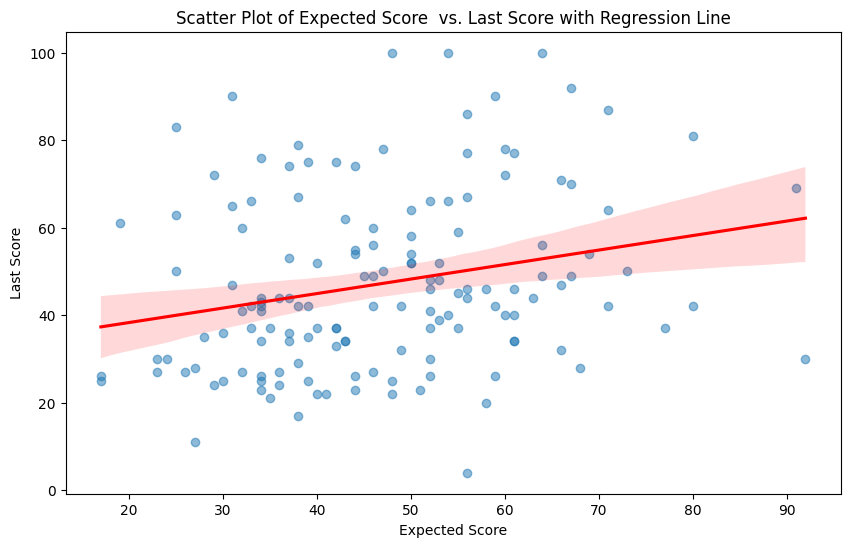

In [95]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming vertical_df is your DataFrame and necessary calculations like SMAPE have been done
filtered_df = filtered_df.replace([np.inf, -np.inf], np.nan)  # Replace inf/-inf with NaN
# filtered_df = filtered_df.dropna(subset=['L9'])  # Drop rows with NaN in 'Risk-Reward Ratio'

# Pearson Correlation
metric = "Expected Score"
print(metric)
pearson_corr = scipy.stats.pearsonr(filtered_df[metric], filtered_df['Last Score'])
print(f"Pearson Correlation Coefficient: {round(pearson_corr[0], 2)}, P-value: {round(pearson_corr[1], 2)}")

# Spearman Correlation
spearman_corr = scipy.stats.spearmanr(filtered_df[metric], filtered_df['Last Score'])
print(f"Spearman Correlation Coefficient: {round(spearman_corr[0], 2)}, P-value: {round(spearman_corr[1], 2)}")

# Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x=metric, y='Last Score', data=filtered_df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Scatter Plot of ' + metric + '  vs. Last Score with Regression Line')
plt.xlabel(metric)
plt.ylabel('Last Score')

top_players_per_club = filtered_df.groupby('Club').apply(lambda x: x.nlargest(5, metric))
# Reset index to avoid MultiIndex after groupby
top_players_per_club = top_players_per_club.reset_index(drop=True)
# Calculate the total 'Last Score' of the selected players
average_last_score_per_player = top_players_per_club['Last Score'].mean()
print(f"Average Last Score per Player: {round(average_last_score_per_player, 1)}")

# Group by 'Club', sum 'Last Score' for the top 5 players in each club, then calculate the average of these sums
average_last_score_per_club = top_players_per_club.groupby('Club')['Last Score'].sum().mean()
print(f"Average 'Last Score' per Club (for top 5 players): {round(average_last_score_per_club, 2)}")
# club_scores = top_players_per_club.groupby('Club')['Last Score'].sum()
# print("\nLast Score for each Club (top 5 players):")
# print(club_scores)

plt.show()

In [96]:
top_players_per_club

,Slug,Lower Bound,Expected Score,Upper Bound,Club,Position,Last Score,L9,xscore,xscorevalue,prob60,prob75,prob90,xdecisive,SMAPE,Deviation,Within Bounds,Score Class
0,bradley-locko,64.0,64.0,64.0,brest-brest,Defender,56.0,64.0,54.27,-3.73,0.3651,0.1203,0.0297,0.05,3.137753,1.73,False,60-70
1,lilian-brassier,40.0,61.0,85.0,brest-brest,Defender,34.0,53.0,52.04,-4.96,0.2980,0.0787,0.0173,0.03,41.933984,18.04,False,60-70
2,marco-bizot,31.0,56.0,80.0,brest-brest,Goalkeeper,67.0,54.0,50.94,-7.06,0.3374,0.1356,0.0149,0.15,27.234187,16.06,True,50-60
3,hugo-magnetti,32.0,53.0,76.0,brest-brest,Midfielder,52.0,48.0,45.59,-2.41,0.1800,0.0475,0.0078,0.12,13.136592,6.41,True,50-60
4,brendan-chardonnet,30.0,52.0,75.0,brest-brest,Defender,66.0,61.0,55.41,-5.59,0.3760,0.1227,0.0325,0.07,17.445021,10.59,True,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,kevin-gameiro,22.0,61.0,63.0,strasbourg-strasbourg,Forward,77.0,34.0,45.89,0.89,0.2640,0.0514,0.0047,0.30,50.630645,31.11,False,60-70
68,lucas-perrin,39.0,61.0,82.0,strasbourg-strasbourg,Defender,34.0,42.0,52.93,5.93,0.3436,0.1154,0.0301,0.03,43.552283,18.93,False,60-70
69,frederic-guilbert,40.0,60.0,88.0,strasbourg-strasbourg,Defender,40.0,50.0,51.06,-0.94,0.3142,0.1016,0.0252,0.04,24.291676,11.06,True,60-70
70,dilane-bakwa,43.0,56.0,67.0,strasbourg-strasbourg,Forward,86.0,61.0,55.19,-1.81,0.3343,0.1502,0.0348,0.27,43.643318,30.81,False,50-60


In [109]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import product
import numpy as np

class ScoringSystem(BaseEstimator, TransformerMixin):
    def __init__(self, weights=None):
        self.weights = weights

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        scores = X.apply(lambda row: self.calculate_score(row), axis=1)
        return scores.values.reshape(-1, 1)

    def calculate_score(self, row):
        score = 0
        for feature, weight in self.weights.items():
            score += row[feature] * weight
        return score

def evaluate_performance(estimator, X, y):
    y_pred = estimator.transform(X).flatten()
    top_n = 10
    top_indices = y_pred.argsort()[-top_n:][::-1]
    actual_top_indices = y.argsort()[-top_n:][::-1]
    precision = len(set(top_indices) & set(actual_top_indices)) / top_n
    return precision

# Load the dataset
df = filtered_df

# Define the features
features = ['Lower Bound', 'Expected Score', 'Upper Bound', 'xscore', 'xscorevalue', 'prob60', 'prob75', 'prob90', 'xdecisive']
step_size = 0.15

# Generate all possible weight combinations with the given step size
all_combinations = list(product(np.arange(0, 1 + step_size, step_size), repeat=len(features)))

# Filter combinations where the sum is 1.0
valid_combinations = [comb for comb in all_combinations if np.isclose(sum(comb), 1.0)]

# Scale the features using Min-Max scaling
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Define the parameter grid for Grid Search
param_grid = []
for combination in valid_combinations:
    weights_dict = {feature: weight for feature, weight in zip(features, combination)}
    param_grid.append({'weights': [weights_dict]})

# Perform Grid Search
scoring_system = ScoringSystem()
grid_search = GridSearchCV(scoring_system, param_grid, cv=5, scoring=evaluate_performance)
grid_search.fit(df[features], df['Last Score'])

# Get the best weights and best score
best_weights = grid_search.best_params_['weights']
best_score = grid_search.best_score_

print("Best Weights:", best_weights)
print("Best Score:", best_score)
# Use the best weights to rank the rows
scoring_system.weights = best_weights
scores = scoring_system.transform(df[features])
df['score'] = scores
ranked_df = df.sort_values('score', ascending=False)

# Print the top-ranked rows
print("Top-ranked rows:")
ranked_df.head(10)